In [1]:
!pip install tensorflow-addons==0.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.9 MB/s eta 0:00:00


In [2]:
# Import Libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [3]:
# Configuration
IMG_SIZE = (180, 180)
BATCH_SIZE = 32
EPOCHS = 100
SEED = 42
CLASS_NAMES = ['Eczema', 'ACNE', 'Psoriasis', 'NORMAL SKIN', 'Others']
BASE_PATH = "/kaggle/input/acne-psoriasis-eczema-vs-all-skin-diseases/Acne_Psoriasis_Eczema_vs_All_skin_Diseases/"
DOMAIN_CLASSES = ['Eczema', 'ACNE', 'Psoriasis']  # Classes in our domain of interest

In [4]:
# 1. Data Preparation
def create_dataframe():
    data_dict = {"image_path": [], "target": []}
    
    class_info = [
        ("Eczema", 0),
        ("ACNE", 1),
        ("Psoriasis", 2),
        ("NORMAL SKIN", 3),
        ("Other", 4)
    ]
    
    for class_dir, label in class_info:
        full_path = os.path.join(BASE_PATH, class_dir)
        if not os.path.exists(full_path):
            raise FileNotFoundError(f"Directory not found: {full_path}")
            
        for img_file in os.listdir(full_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(full_path, img_file)
                data_dict["image_path"].append(img_path)
                data_dict["target"].append(label)
                
    return pd.DataFrame(data_dict)

df = create_dataframe()
print("Class distribution:\n", df['target'].value_counts())

Class distribution:
 target
4    31851
1     4197
2     3812
0     3200
3     2158
Name: count, dtype: int64


In [5]:
# 2. Handle Class Imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(df['target']), y=df['target'])
class_weights = dict(enumerate(class_weights))
print("\nClass weights:", class_weights)


Class weights: {0: 2.826125, 1: 2.154777221825113, 2: 2.372402938090241, 3: 4.190732159406858, 4: 0.28393457034316033}


In [6]:
# 3. Image Loading and Preprocessing
def load_images(df):
    images = []
    labels = []
    
    for idx, row in df.iterrows():
        try:
            img = cv2.imread(row['image_path'])
            if img is None:
                raise ValueError("Could not read image")
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            images.append(img)
            labels.append(row['target'])
        except Exception as e:
            print(f"Error processing {row['image_path']}: {str(e)}")
    
    return np.array(images), np.array(labels)

images, labels = load_images(df)

In [7]:
# 4. Data Splitting
X_train, X_test, y_train, y_test = train_test_split(
    images, 
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=SEED
)


In [8]:
# 5. Feature Extraction with VGG19
def create_feature_extractor():
    base_model = VGG19(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )
    base_model.trainable = False
    return base_model

vgg_model = create_feature_extractor()

def extract_features(images, model):
    features = model.predict(images, verbose=0)
    return features.reshape(features.shape[0], -1)

print("\nExtracting training features...")
X_train_features = extract_features(X_train, vgg_model)
print("Extracting test features...")
X_test_features = extract_features(X_test, vgg_model)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Extracting training features...
Extracting test features...


In [9]:
# 6. Simplified Model Architecture
def build_model(input_shape):
    model = Sequential([
        Dense(512, activation='relu', 
              input_shape=input_shape,
              kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(256, activation='relu',
              kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(5, activation='softmax')  # Updated to 5 classes
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model((X_train_features.shape[1],))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │       6,554,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,686,725 (25.51 MB)

 Trainable params: 6,686,725 (25.51 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# 7. Training with Essential Callbacks Only
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=15,
        verbose=1
    )
]

In [11]:
history = model.fit(
    X_train_features, y_train,
    validation_data=(X_test_features, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5310 - loss: 16.4123 - val_accuracy: 0.6732 - val_loss: 11.4800 - learning_rate: 1.0000e-04
Epoch 2/100
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6330 - loss: 11.0267 - val_accuracy: 0.6558 - val_loss: 9.3004 - learning_rate: 1.0000e-04
Epoch 3/100
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6518 - loss: 8.7047 - val_accuracy: 0.6578 - val_loss: 7.2084 - learning_rate: 1.0000e-04
Epoch 4/100
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6691 - loss: 6.5434 - val_accuracy: 0.6865 - val_loss: 5.2138 - learning_rate: 1.0000e-04
Epoch 5/100
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6931 - loss: 4.6696 - val_accuracy: 0.6944 - val_loss: 3.7294 - learning_rate: 1.0000e-04
Epoch 6/100
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7143 - loss: 3.3012 - val_accuracy: 0.7209 - val_loss: 2.7369 - learning_rate: 1.0000e-04
Epoch 7/100
1131/1131 ━━━━━━━━━━━━━━━━━━━━

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

      Eczema       0.60      0.86      0.71       640
        ACNE       0.82      0.87      0.85       839
   Psoriasis       0.56      0.85      0.68       762
 NORMAL SKIN       0.87      0.99      0.92       432
      Others       0.97      0.85      0.90      6371

    accuracy                           0.86      9044
   macro avg       0.76      0.88      0.81      9044
weighted avg       0.89      0.86      0.87      9044



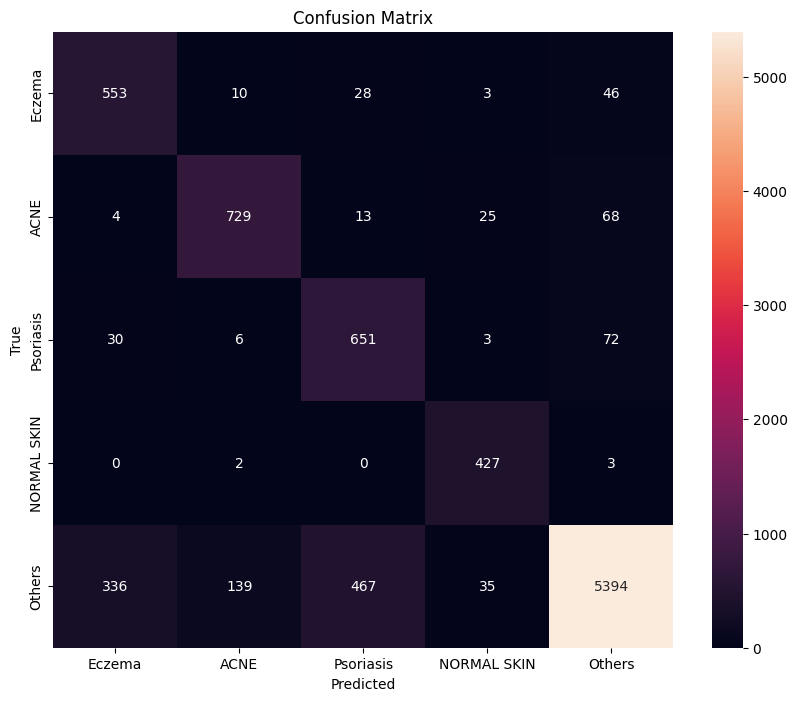

In [12]:
# 8. Post-Training Evaluation
y_pred = np.argmax(model.predict(X_test_features), axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [13]:
# Function to interpret predictions
def interpret_prediction(class_index):
    class_name = CLASS_NAMES[class_index]
    if class_name in DOMAIN_CLASSES:
        return f"Predicted: {class_name}"
    else:
        return "Not in my domain"

In [14]:
# Display some examples with interpretations
print("\nSample Test Predictions with Interpretations:")
for i in range(min(10, len(y_test))):
    true_class = CLASS_NAMES[y_test[i]]
    pred_class = CLASS_NAMES[y_pred[i]]
    interpretation = interpret_prediction(y_pred[i])
    print(f"Sample {i+1}: True class = {true_class}, {interpretation}")


Sample Test Predictions with Interpretations:
Sample 1: True class = Others, Not in my domain
Sample 2: True class = Others, Not in my domain
Sample 3: True class = Others, Not in my domain
Sample 4: True class = Psoriasis, Predicted: Psoriasis
Sample 5: True class = Eczema, Predicted: Eczema
Sample 6: True class = ACNE, Predicted: ACNE
Sample 7: True class = Psoriasis, Predicted: Psoriasis
Sample 8: True class = Eczema, Predicted: Eczema
Sample 9: True class = Others, Predicted: Psoriasis
Sample 10: True class = ACNE, Predicted: ACNE


In [15]:
# 9. Save Model
model.save('skin_disease_classifier_v2.h5')
print("Model saved successfully!")
import shutil
shutil.move('skin_disease_classifier_v2.h5', '/kaggle/working/skin_disease_classifier_v2.h5')

Model saved successfully!


'/kaggle/working/skin_disease_classifier_v2.h5'

In [16]:
# Load the saved model (if not already loaded)
from tensorflow.keras.models import load_model
import numpy as np

# 1. Load the trained model
model = load_model('skin_disease_classifier_v2.h5')

# 2. Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test_features, y_test, verbose=0)

# 3. Print results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 85.74%
Test Loss: 0.6933


In [17]:
# Optional: Detailed prediction analysis
from sklearn.metrics import accuracy_score

# Make predictions
y_pred = model.predict(X_test_features)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate manual accuracy (should match evaluate() result)
manual_accuracy = accuracy_score(y_test, y_pred_classes)
print(f"\nManual Accuracy Check: {manual_accuracy * 100:.2f}%")

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Manual Accuracy Check: 85.74%


In [18]:
# Confirmation check
assert np.isclose(test_accuracy, manual_accuracy), "Accuracy values should match!"

# Analyze in-domain vs out-of-domain predictions
domain_indices = np.array([i for i, name in enumerate(CLASS_NAMES) if name in DOMAIN_CLASSES])
in_domain_samples = np.isin(y_test, domain_indices)
out_domain_samples = ~in_domain_samples

# For in-domain samples (the 3 main diseases)
if np.any(in_domain_samples):
    in_domain_accuracy = accuracy_score(y_test[in_domain_samples], y_pred_classes[in_domain_samples])
    print(f"\nMain Diseases Accuracy: {in_domain_accuracy * 100:.2f}%")

# For out-of-domain samples
if np.any(out_domain_samples):
    # For these, we want to check if the model correctly identified them as not in domain
    correctly_identified = np.isin(y_pred_classes[out_domain_samples], [3, 4])  # NORMAL SKIN or Others
    print(f"Not-in-domain recognition rate: {np.mean(correctly_identified) * 100:.2f}%")



Main Diseases Accuracy: 86.26%
Not-in-domain recognition rate: 86.12%


In [19]:
# Function for making a prediction on a new image
def predict_skin_condition(image_path):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = np.expand_dims(img, axis=0)
    
    # Extract features using VGG19
    features = vgg_model.predict(img, verbose=0)
    features = features.reshape(1, -1)
    
    # Make prediction
    prediction = model.predict(features, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class] * 100
    
    # Interpret the result
    if predicted_class in [0, 1, 2]:  # Main diseases
        result = f"Prediction: {CLASS_NAMES[predicted_class]} (Confidence: {confidence:.2f}%)"
    else:  # NORMAL SKIN or Others
        result = f"Not in my domain (Detected as: {CLASS_NAMES[predicted_class]}, Confidence: {confidence:.2f}%)"
        
    return result

Example predictions on test samples:

Sample 8588:
True class: Others
Not in my domain (Detected as: NORMAL SKIN, Confidence: 55.93%)


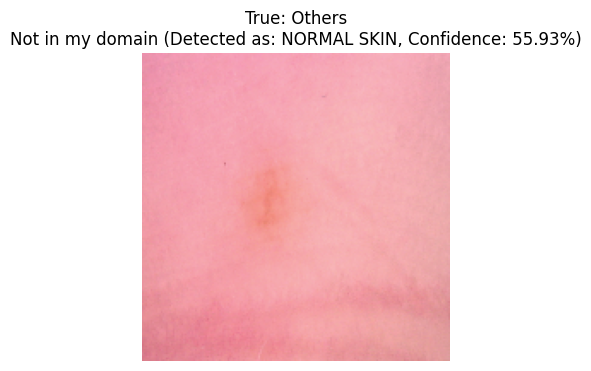


Sample 563:
True class: Others
Not in my domain (Detected as: Others, Confidence: 46.19%)


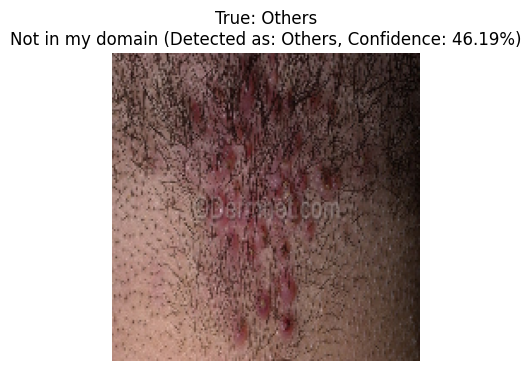


Sample 1934:
True class: Others
Prediction: ACNE (Confidence: 83.41%)


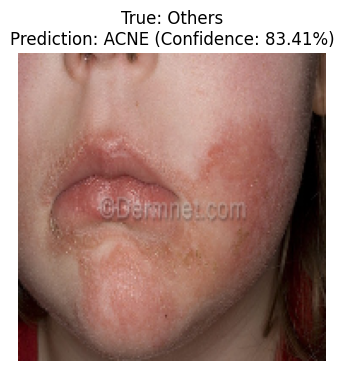


Sample 3625:
True class: Psoriasis
Prediction: Psoriasis (Confidence: 67.71%)


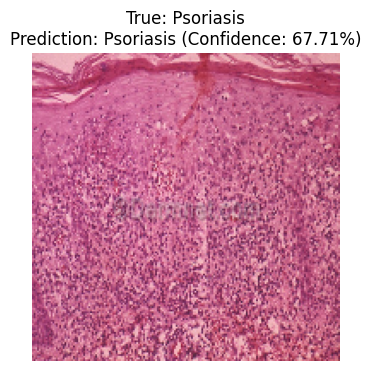


Sample 6454:
True class: Others
Not in my domain (Detected as: Others, Confidence: 100.00%)


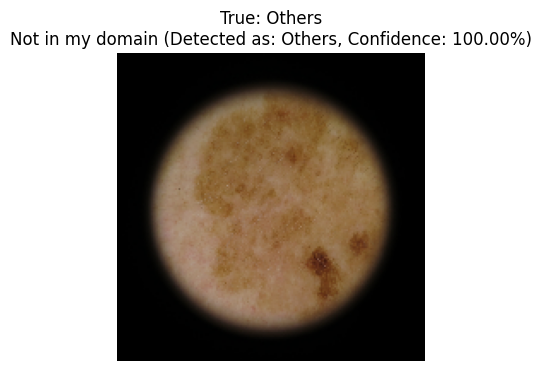

In [20]:
# Test the prediction function on a few sample images if available
import random

# Test with some random samples from the test set (if available)
print("Example predictions on test samples:")
test_indices = random.sample(range(len(X_test)), min(5, len(X_test)))

for idx in test_indices:
    # Save the test image temporarily
    temp_img_path = f"temp_test_image_{idx}.jpg"
    plt.imsave(temp_img_path, X_test[idx])
    
    # Make prediction
    true_class = CLASS_NAMES[y_test[idx]]
    prediction_result = predict_skin_condition(temp_img_path)
    
    # Display results
    print(f"\nSample {idx}:")
    print(f"True class: {true_class}")
    print(f"{prediction_result}")
    
    # Display the image
    plt.figure(figsize=(4, 4))
    plt.imshow(X_test[idx])
    plt.title(f"True: {true_class}\n{prediction_result}")
    plt.axis('off')
    plt.show()
    
    # Clean up
    os.remove(temp_img_path)

In [21]:
# 10. Hyperparameter Tuning
from sklearn.model_selection import ParameterGrid
import time
import datetime
import json
from tensorflow.keras.models import clone_model

# Define hyperparameter grid
param_grid = {
    'learning_rate': [1e-3, 1e-4, 5e-5],
    'batch_size': [16, 32, 64],
    'dropout1': [0.3, 0.5, 0.7],
    'dropout2': [0.2, 0.3, 0.5],
    'l2_reg': [0.001, 0.01, 0.1],
    'units1': [256, 512, 1024],
    'units2': [128, 256, 512]
}

# Limit the search space for quicker execution
# You can remove this to explore the full parameter space
limited_param_grid = {
    'learning_rate': [1e-3, 1e-4],
    'batch_size': [32, 64],
    'dropout1': [0.3, 0.5],
    'dropout2': [0.3],
    'l2_reg': [0.01, 0.1],
    'units1': [512],
    'units2': [256]
}

# Create a smaller grid for faster execution (use this for initial testing)
minimal_param_grid = {
    'learning_rate': [1e-3, 1e-4],
    'batch_size': [32],
    'dropout1': [0.5],
    'dropout2': [0.3],
    'l2_reg': [0.01],
    'units1': [512],
    'units2': [256]
}

# Choose which grid to use (minimal for quick testing, limited for reasonable search, param_grid for full search)
active_grid = minimal_param_grid  # Change this to use different grid sizes

# Initialize tracking variables
best_val_accuracy = 0.0
best_params = None
best_model = None
results = []

# Function to build model with specified hyperparameters
def build_model_with_params(input_shape, params):
    model = Sequential([
        Dense(params['units1'], activation='relu', 
              input_shape=input_shape,
              kernel_regularizer=l2(params['l2_reg'])),
        Dropout(params['dropout1']),
        Dense(params['units2'], activation='relu',
              kernel_regularizer=l2(params['l2_reg'])),
        Dropout(params['dropout2']),
        Dense(5, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Set up callbacks
def get_callbacks():
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=0
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            verbose=0
        )
    ]

# Create a timestamp-based directory for saving models
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_dir = f"model_tuning_{timestamp}"
os.makedirs(model_dir, exist_ok=True)

# Initialize parameter grid
grid = list(ParameterGrid(active_grid))
print(f"Total parameter combinations to try: {len(grid)}")

# Iterate through hyperparameter combinations
for i, params in enumerate(grid):
    print(f"\nRunning model {i+1}/{len(grid)} with parameters:\n{params}")
    start_time = time.time()
    
    # Build and train model
    model = build_model_with_params((X_train_features.shape[1],), params)
    
    # Train the model
    history = model.fit(
        X_train_features, y_train,
        validation_data=(X_test_features, y_test),
        epochs=15,  # Reduced epochs for hyperparameter search
        batch_size=params['batch_size'],
        class_weight=class_weights,
        callbacks=get_callbacks(),
        verbose=0
    )
    
    # Evaluate the model
    train_loss, train_acc = model.evaluate(X_train_features, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_test_features, y_test, verbose=0)
    
    # Record results
    elapsed_time = time.time() - start_time
    result = {
        'params': params,
        'train_accuracy': float(train_acc),
        'val_accuracy': float(val_acc),
        'train_loss': float(train_loss),
        'val_loss': float(val_loss),
        'training_time': elapsed_time
    }
    results.append(result)
    
    # Track best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_params = params
        
        # Save this model
        model_path = os.path.join(model_dir, f"model_{i+1}_val_acc_{val_acc:.4f}.h5")
        model.save(model_path)
        best_model = model_path
        
        print(f"New best model saved to {model_path}")
    
    print(f"Model {i+1} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Time: {elapsed_time:.2f}s")
    
    # Save results after each iteration
    with open(os.path.join(model_dir, 'tuning_results.json'), 'w') as f:
        json.dump(results, f, indent=4)

# Print and save final results
print(f"\nBest model achieved {best_val_accuracy:.4f} validation accuracy with parameters:")
for k, v in best_params.items():
    print(f"{k}: {v}")
print(f"Best model saved to: {best_model}")

# Create results dataframe for easy analysis
results_df = pd.DataFrame(results)
print("\nTop 5 models by validation accuracy:")
display(results_df.sort_values('val_accuracy', ascending=False).head(5))

# Save the results as CSV for further analysis
results_df.to_csv(os.path.join(model_dir, 'hyperparameter_results.csv'), index=False)
print(f"Results saved to {os.path.join(model_dir, 'hyperparameter_results.csv')}")

Total parameter combinations to try: 2

Running model 1/2 with parameters:
{'batch_size': 32, 'dropout1': 0.5, 'dropout2': 0.3, 'l2_reg': 0.01, 'learning_rate': 0.001, 'units1': 512, 'units2': 256}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


New best model saved to model_tuning_20250315-151251/model_1_val_acc_0.6211.h5
Model 1 - Train Acc: 0.6329, Val Acc: 0.6211, Time: 75.39s

Running model 2/2 with parameters:
{'batch_size': 32, 'dropout1': 0.5, 'dropout2': 0.3, 'l2_reg': 0.01, 'learning_rate': 0.0001, 'units1': 512, 'units2': 256}
New best model saved to model_tuning_20250315-151251/model_2_val_acc_0.8236.h5
Model 2 - Train Acc: 0.8786, Val Acc: 0.8236, Time: 75.43s

Best model achieved 0.8236 validation accuracy with parameters:
batch_size: 32
dropout1: 0.5
dropout2: 0.3
l2_reg: 0.01
learning_rate: 0.0001
units1: 512
units2: 256
Best model saved to: model_tuning_20250315-151251/model_2_val_acc_0.8236.h5

Top 5 models by validation accuracy:


,params,train_accuracy,val_accuracy,train_loss,val_loss,training_time
1,"{'batch_size': 32, 'dropout1': 0.5, 'dropout2'...",0.878587,0.823640,0.781732,0.915445,75.426635
0,"{'batch_size': 32, 'dropout1': 0.5, 'dropout2'...",0.632913,0.621075,1.291246,1.316331,75.394628


Results saved to model_tuning_20250315-151251/hyperparameter_results.csv


In [22]:
# 11. Train the Final Model with Best Hyperparameters
import os
import time

# Use the best parameters found in hyperparameter tuning
# If you haven't run the tuning, use these default best parameters
if 'best_params' not in locals() or best_params is None:
    best_params = {
        'learning_rate': 1e-4,
        'batch_size': 32,
        'dropout1': 0.5,
        'dropout2': 0.3,
        'l2_reg': 0.01,
        'units1': 512,
        'units2': 256
    }

print("Training final model with best hyperparameters:")
for k, v in best_params.items():
    print(f"{k}: {v}")

# Build the final model with best hyperparameters
final_model = build_model_with_params((X_train_features.shape[1],), best_params)

# Set up callbacks for final training
final_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,  # Increased patience for final model
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        verbose=1
    )
]

# Final model training with more epochs
start_time = time.time()
final_history = final_model.fit(
    X_train_features, y_train,
    validation_data=(X_test_features, y_test),
    epochs=100,  # Full training run
    batch_size=best_params['batch_size'],
    class_weight=class_weights,
    callbacks=final_callbacks,
    verbose=1
)

# Calculate training time
training_time = time.time() - start_time
print(f"\nFinal model training completed in {training_time:.2f} seconds")

# Save the final model
final_model_path = 'skin_disease_classifier_final.h5'
final_model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

# Copy to working directory if using Kaggle
try:
    import shutil
    shutil.copy(final_model_path, '/kaggle/working/skin_disease_classifier_final.h5')
    print("Model copied to Kaggle working directory")
except Exception as e:
    print(f"Could not copy to Kaggle working directory: {str(e)}")

Training final model with best hyperparameters:
batch_size: 32
dropout1: 0.5
dropout2: 0.3
l2_reg: 0.01
learning_rate: 0.0001
units1: 512
units2: 256


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5255 - loss: 16.7225 - val_accuracy: 0.6395 - val_loss: 11.5156 - learning_rate: 1.0000e-04
Epoch 2/100
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6193 - loss: 11.1144 - val_accuracy: 0.6552 - val_loss: 9.3882 - learning_rate: 1.0000e-04
Epoch 3/100
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6458 - loss: 8.7977 - val_accuracy: 0.6630 - val_loss: 7.2620 - learning_rate: 1.0000e-04
Epoch 4/100
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6637 - loss: 6.6643 - val_accuracy: 0.6727 - val_loss: 5.3829 - learning_rate: 1.0000e-04
Epoch 5/100
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6808 - loss: 4.8144 - val_accuracy: 0.7063 - val_loss: 3.8325 - learning_rate: 1.0000e-04
Epoch 6/100
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6969 - loss: 3.3781 - val_accuracy: 0.7477 - val_loss: 2.7241 - learning_rate: 1.0000e-04
Epoch 7/100
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 

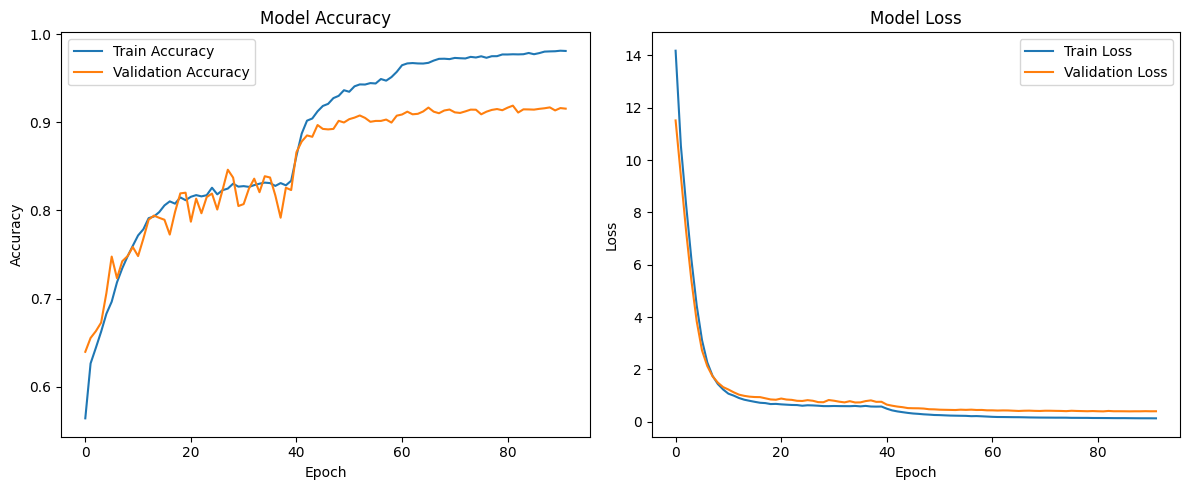


Evaluating final model performance:
Test Accuracy: 91.91%
Test Loss: 0.3926
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

      Eczema       0.79      0.86      0.83       640
        ACNE       0.89      0.88      0.88       839
   Psoriasis       0.74      0.86      0.80       762
 NORMAL SKIN       0.94      0.97      0.95       432
      Others       0.96      0.93      0.95      6371

    accuracy                           0.92      9044
   macro avg       0.87      0.90      0.88      9044
weighted avg       0.92      0.92      0.92      9044



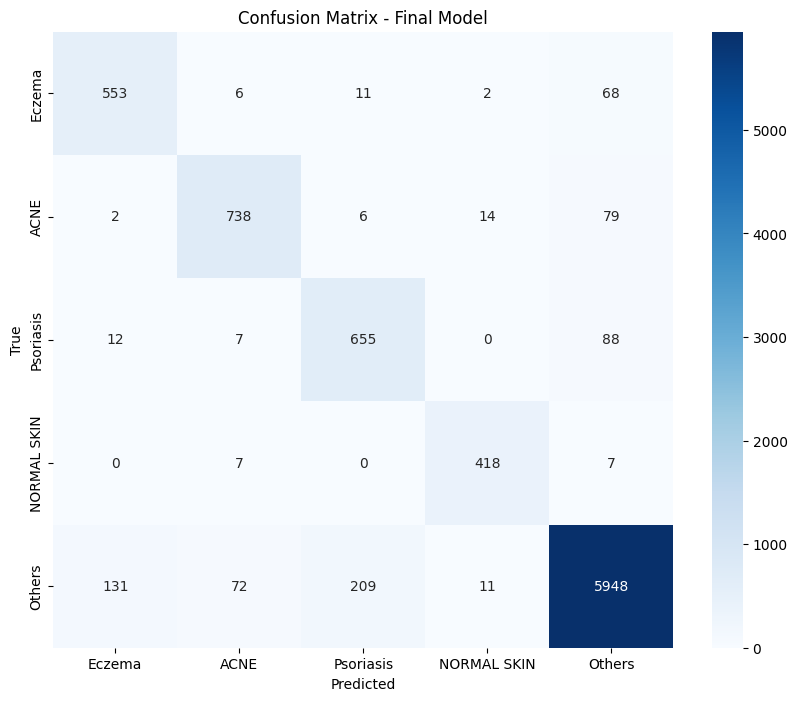


Per-class Metrics:


,Class,Sensitivity/Recall,Precision,F1-Score
0,Eczema,0.864062,0.792264,0.826607
1,ACNE,0.879619,0.889157,0.884362
2,Psoriasis,0.859580,0.743473,0.797322
3,NORMAL SKIN,0.967593,0.939326,0.953250
4,Others,0.933605,0.960905,0.947058



In-domain accuracy (3 main diseases): 86.84%
Out-domain accuracy (Normal/Others): 93.58%
Not-in-domain recognition rate: 93.84%


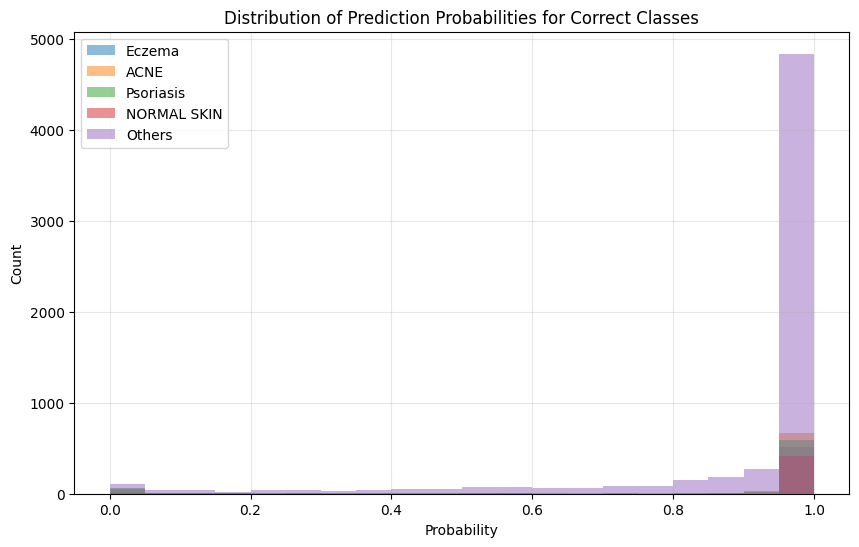

In [23]:
# 12. Visualize Training History and Evaluate Final Model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'], label='Train Accuracy')
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(final_history.history['loss'], label='Train Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
print("\nEvaluating final model performance:")
final_loss, final_accuracy = final_model.evaluate(X_test_features, y_test, verbose=0)
print(f"Test Accuracy: {final_accuracy * 100:.2f}%")
print(f"Test Loss: {final_loss:.4f}")

# Make predictions
y_pred_probs = final_model.predict(X_test_features)
y_pred = np.argmax(y_pred_probs, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

# Display confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix - Final Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Compute metrics per class
sensitivity = np.diag(cm) / np.sum(cm, axis=1)
precision = np.diag(cm) / np.sum(cm, axis=0)

# Create a dataframe for metrics
metrics_df = pd.DataFrame({
    'Class': CLASS_NAMES,
    'Sensitivity/Recall': sensitivity,
    'Precision': precision,
    'F1-Score': 2 * (precision * sensitivity) / (precision + sensitivity)
})

print("\nPer-class Metrics:")
display(metrics_df)

# Analyze in-domain vs out-of-domain performance
domain_indices = np.array([i for i, name in enumerate(CLASS_NAMES) if name in DOMAIN_CLASSES])
in_domain_samples = np.isin(y_test, domain_indices)
out_domain_samples = ~in_domain_samples

# Report domain-specific performance
if np.any(in_domain_samples):
    in_domain_acc = np.mean(y_pred[in_domain_samples] == y_test[in_domain_samples])
    print(f"\nIn-domain accuracy (3 main diseases): {in_domain_acc * 100:.2f}%")

if np.any(out_domain_samples):
    out_domain_acc = np.mean(y_pred[out_domain_samples] == y_test[out_domain_samples])
    print(f"Out-domain accuracy (Normal/Others): {out_domain_acc * 100:.2f}%")
    
    # For these, we want to check if the model correctly identified them as not in domain
    correctly_identified = np.isin(y_pred[out_domain_samples], [3, 4])  # NORMAL SKIN or Others
    print(f"Not-in-domain recognition rate: {np.mean(correctly_identified) * 100:.2f}%")

# Prediction probability distribution analysis
plt.figure(figsize=(10, 6))
for i, class_name in enumerate(CLASS_NAMES):
    # Get samples where true class is i
    class_indices = np.where(y_test == i)[0]
    if len(class_indices) > 0:
        # Get prediction probabilities for the correct class
        probs = y_pred_probs[class_indices, i]
        plt.hist(probs, alpha=0.5, bins=20, label=class_name)

plt.title('Distribution of Prediction Probabilities for Correct Classes')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Example predictions with final model:

Sample 6308:
True class: Others
Not in my domain (Detected as: Others, Confidence: 82.82%)
Class probabilities:
  Others: 82.82%
  ACNE: 16.71%
  NORMAL SKIN: 0.34%
  Psoriasis: 0.08%
  Eczema: 0.06%


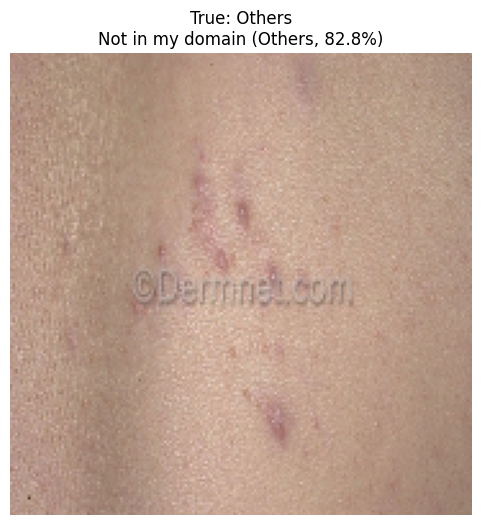


Sample 2815:
True class: Others
Not in my domain (Detected as: Others, Confidence: 99.99%)
Class probabilities:
  Others: 99.99%
  ACNE: 0.01%
  NORMAL SKIN: 0.00%
  Psoriasis: 0.00%
  Eczema: 0.00%


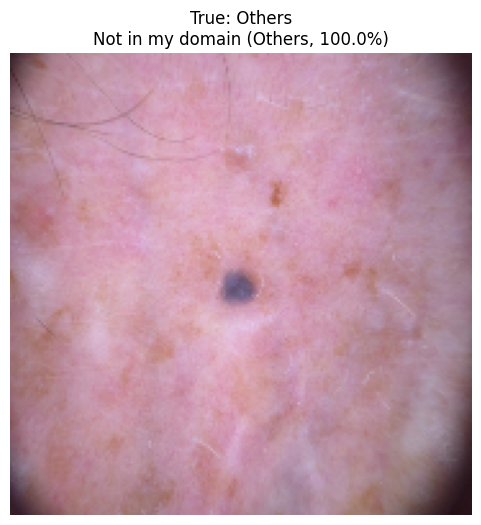


Sample 1236:
True class: Others
Not in my domain (Detected as: Others, Confidence: 97.93%)
Class probabilities:
  Others: 97.93%
  ACNE: 1.88%
  Psoriasis: 0.09%
  Eczema: 0.08%
  NORMAL SKIN: 0.02%


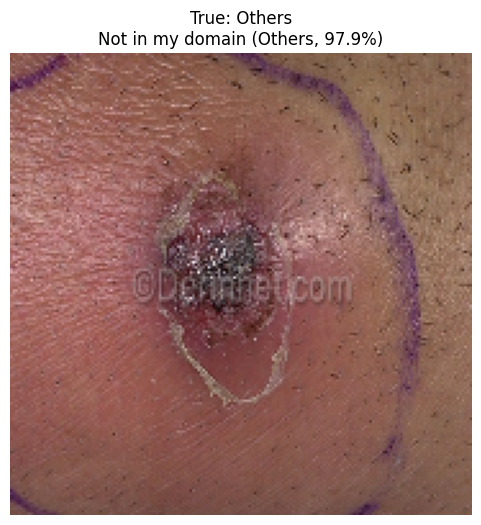


Sample 3314:
True class: Others
Not in my domain (Detected as: Others, Confidence: 99.96%)
Class probabilities:
  Others: 99.96%
  ACNE: 0.01%
  Eczema: 0.01%
  Psoriasis: 0.01%
  NORMAL SKIN: 0.00%


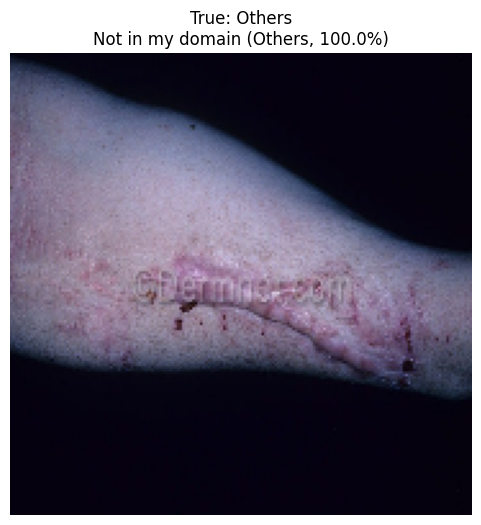


Sample 2716:
True class: ACNE
Prediction: ACNE (Confidence: 99.99%)
Class probabilities:
  ACNE: 99.99%
  Others: 0.00%
  NORMAL SKIN: 0.00%
  Eczema: 0.00%
  Psoriasis: 0.00%


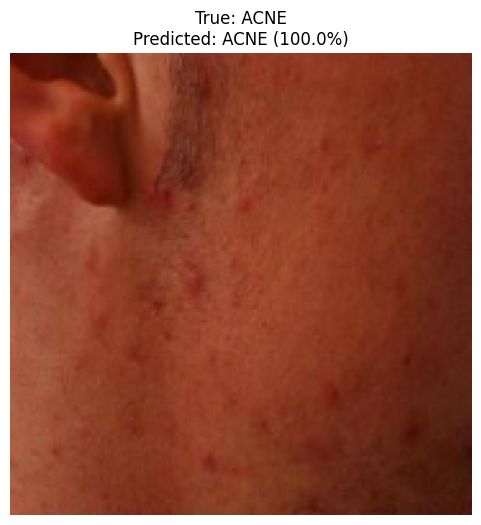

In [24]:
# 13. Test Prediction Function with Final Model
import random
import matplotlib.pyplot as plt

# Update prediction function to use the final model
def predict_skin_condition_final(image_path, model=final_model):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        return "Error: Could not read image"
        
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = np.expand_dims(img, axis=0)
    
    # Extract features using VGG19
    features = vgg_model.predict(img, verbose=0)
    features = features.reshape(1, -1)
    
    # Make prediction
    prediction = model.predict(features, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class] * 100
    
    # Get all class probabilities
    all_probs = {CLASS_NAMES[i]: prediction[0][i] * 100 for i in range(len(CLASS_NAMES))}
    
    # Interpret the result
    if predicted_class in [0, 1, 2]:  # Main diseases
        result = f"Prediction: {CLASS_NAMES[predicted_class]} (Confidence: {confidence:.2f}%)"
    else:  # NORMAL SKIN or Others
        result = f"Not in my domain (Detected as: {CLASS_NAMES[predicted_class]}, Confidence: {confidence:.2f}%)"
        
    return result, all_probs, predicted_class

# Test with random samples from the test set
print("Example predictions with final model:")
test_indices = random.sample(range(len(X_test)), min(5, len(X_test)))

for idx in test_indices:
    # Save the test image temporarily
    temp_img_path = f"temp_test_image_{idx}.jpg"
    plt.imsave(temp_img_path, X_test[idx])
    
    # Make prediction
    true_class = CLASS_NAMES[y_test[idx]]
    prediction_result, all_probs, predicted_class = predict_skin_condition_final(temp_img_path)
    
    # Display results
    print(f"\nSample {idx}:")
    print(f"True class: {true_class}")
    print(f"{prediction_result}")
    
    # Print all probabilities
    print("Class probabilities:")
    for cls, prob in sorted(all_probs.items(), key=lambda x: x[1], reverse=True):
        print(f"  {cls}: {prob:.2f}%")
    
    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(X_test[idx])
    if predicted_class in [0, 1, 2]:
        plt.title(f"True: {true_class}\nPredicted: {CLASS_NAMES[predicted_class]} ({all_probs[CLASS_NAMES[predicted_class]]:.1f}%)")
    else:
        plt.title(f"True: {true_class}\nNot in my domain ({CLASS_NAMES[predicted_class]}, {all_probs[CLASS_NAMES[predicted_class]]:.1f}%)")
    plt.axis('off')
    plt.show()
    
    # Clean up
    os.remove(temp_img_path)